In [17]:
import matplotlib.pyplot as plt

import pyclesperanto as cle
import cupy as cp
import numpy as np
import time

cle.select_device(1,"gpu")

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.230.02
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

In [18]:
# Support function for the benchmark
import math

def handle_prime(p,x,a):
    log = math.log(p)
    power=p

    while power <= x + a.shape[0]:
        j=x%power
        if j>0:
            j=power-j

        while j < a.shape[0]:
            a[j]+=log
            j+=power

        power*=p
    

def next_smooth(x):
    """[summary]
    author Johannes Schindelin
    author Brian Northan

    A class to determine the next smooth number (a number divisable only)
    by prime numbers up to k (in this case we fix k at 7).
    
    Based on A. Granville, Finding smooth numbers computationally.
    
    Args:
        x ([type]): number to test

    Returns:
        [type]: next smooth number larger than x
    """
    z = int(10*math.log2(x))
    delta = 0.000001

    a = np.zeros(z)

    handle_prime(2,x,a)
    handle_prime(3,x,a)
    handle_prime(5,x,a)
    handle_prime(7,x,a)

    log = math.log(x)
    for i in range(a.shape[0]):
        if a[i] >=log-delta:
            return x+i

    return -1

def get_next_smooth(size):
    """ for an nd tuble compute the next smooth size for each element

    Args:
        size ([type]): nd input tuple 

    Returns:
        [type]: tuple containing the next smooth size for each input element
    """
    return tuple(map(lambda i: next_smooth(i), size))

def get_pad_size(img, psf):
    """ given an image and psf return the extended size needed to avoid circular calculations
    during convolution and/or deconvolution 

    Args:
        img ([type]): nd image
        psf ([type]): nd psf 

    Returns:
        [tuple]: extended size to use to avoid circular calculations
    """
    return tuple(map(lambda i,j: i+2*math.floor(j/2),img.shape,psf.shape))


def pad(img, paddedsize, mode, constant_values=0):
    """ pad image to paddedsize

    Args:
        img ([type]): image to pad 
        paddedsize ([type]): size to pad to 
        mode ([type]): one of the np.pad modes

    Returns:
        padded [nd array]: padded image
        padding [tuple]: tuple containing the padding used
    """
    padding = tuple(map(lambda i,j: ( math.ceil((i-j)/2), math.floor((i-j)/2) ),paddedsize,img.shape))

    if mode == 'constant':
        return np.pad(img, padding,mode, constant_values=constant_values), padding
    else:
        return np.pad(img, padding,mode), padding

In [19]:
# Function to benchmark FFT full pyclesperanto 
def benchmark_fft(min_size=100, max_size=150, n=10):
    sizes = range(min_size, max_size+1, n)
    times = []
    times_smooth = []

    for size in sizes:
        # Create a random 2D array of the given size
        x = np.random.random((size, size)).astype(np.float32)
        next_smooth = cle.__experimental__.fft_smooth_shape([size, size])
        nx = next_smooth[1] - size
        ny = next_smooth[0] - size
       
        cx = cle.push(x)
        cx_padded = cle.__experimental__.pad(x, x_pad=nx, y_pad=ny, center=True)
        
        # Perform FFT n times and measure the time taken
        start_time = time.time()
        for _ in range(n):
            toto = cle.__experimental__.fft(cx, None)
        end_time = time.time()

        start_time_smooth = time.time()
        for _ in range(n):
            _ = cle.__experimental__.fft(cx_padded, None)
        end_time_smooth = time.time()
        
        # Calculate the average time per FFT
        avg_time = (end_time - start_time) / n
        avg_time_smooth = (end_time_smooth - start_time_smooth) / n
        times.append(avg_time)
        times_smooth.append(avg_time_smooth)
        print(f"Size: {size}x{size}, Smooth Size: {next_smooth[0]}, Avg Time: {avg_time:.6f} seconds, Avg Time Smooth: {avg_time_smooth:.6f} seconds")

    return sizes, times, times_smooth

# Run the benchmark
sizes, cle_times_1, cle_times_smooth_1 = benchmark_fft(1010, 1024, 1)

Size: 1010x1010, Smooth Size: 1024, Avg Time: 0.004748 seconds, Avg Time Smooth: 0.002191 seconds
Size: 1011x1011, Smooth Size: 1024, Avg Time: 0.004138 seconds, Avg Time Smooth: 0.002094 seconds
Size: 1012x1012, Smooth Size: 1024, Avg Time: 0.005342 seconds, Avg Time Smooth: 0.002083 seconds
Size: 1013x1013, Smooth Size: 1024, Avg Time: 0.007828 seconds, Avg Time Smooth: 0.002044 seconds
Size: 1014x1014, Smooth Size: 1024, Avg Time: 0.003119 seconds, Avg Time Smooth: 0.002038 seconds
Size: 1015x1015, Smooth Size: 1024, Avg Time: 0.003477 seconds, Avg Time Smooth: 0.002048 seconds
Size: 1016x1016, Smooth Size: 1024, Avg Time: 0.006211 seconds, Avg Time Smooth: 0.002102 seconds
Size: 1017x1017, Smooth Size: 1024, Avg Time: 0.005810 seconds, Avg Time Smooth: 0.002063 seconds
Size: 1018x1018, Smooth Size: 1024, Avg Time: 0.007380 seconds, Avg Time Smooth: 0.002044 seconds
Size: 1019x1019, Smooth Size: 1024, Avg Time: 0.007362 seconds, Avg Time Smooth: 0.002055 seconds
Size: 1020x1020, Smo

In [20]:
# Function to benchmark FFT pyclesperanto with numpy support function
def benchmark_fft(min_size=100, max_size=150, n=10):
    sizes = range(min_size, max_size+1, n)
    times = []
    times_smooth = []

    for size in sizes:
        # Create a random 2D array of the given size
        x = np.random.random((size, size)).astype(np.float32)
        next_smooth = get_next_smooth([size, size])
        x_padded, _ = pad(x, next_smooth, "constant")
       
        cx = cle.push(x)
        cx_padded = cle.push(x_padded)
        
        # Perform FFT n times and measure the time taken
        start_time = time.time()
        for _ in range(n):
            toto = cle.__experimental__.fft(cx, None)
        end_time = time.time()

        start_time_smooth = time.time()
        for _ in range(n):
            _ = cle.__experimental__.fft(cx_padded, None)
        end_time_smooth = time.time()
        
        # Calculate the average time per FFT
        avg_time = (end_time - start_time) / n
        avg_time_smooth = (end_time_smooth - start_time_smooth) / n
        times.append(avg_time)
        times_smooth.append(avg_time_smooth)
        print(f"Size: {size}x{size}, Smooth Size: {next_smooth[0]}, Avg Time: {avg_time:.6f} seconds, Avg Time Smooth: {avg_time_smooth:.6f} seconds")

    return sizes, times, times_smooth

# Run the benchmark
sizes, cle_times_2, cle_times_smooth_2 = benchmark_fft(1010, 1024, 1)

Size: 1010x1010, Smooth Size: 1024, Avg Time: 0.004719 seconds, Avg Time Smooth: 0.002115 seconds
Size: 1011x1011, Smooth Size: 1024, Avg Time: 0.004210 seconds, Avg Time Smooth: 0.002075 seconds
Size: 1012x1012, Smooth Size: 1024, Avg Time: 0.005280 seconds, Avg Time Smooth: 0.002281 seconds
Size: 1013x1013, Smooth Size: 1024, Avg Time: 0.007415 seconds, Avg Time Smooth: 0.002075 seconds
Size: 1014x1014, Smooth Size: 1024, Avg Time: 0.003122 seconds, Avg Time Smooth: 0.002111 seconds
Size: 1015x1015, Smooth Size: 1024, Avg Time: 0.003593 seconds, Avg Time Smooth: 0.002112 seconds
Size: 1016x1016, Smooth Size: 1024, Avg Time: 0.006362 seconds, Avg Time Smooth: 0.002122 seconds
Size: 1017x1017, Smooth Size: 1024, Avg Time: 0.005758 seconds, Avg Time Smooth: 0.002105 seconds
Size: 1018x1018, Smooth Size: 1024, Avg Time: 0.007502 seconds, Avg Time Smooth: 0.002098 seconds
Size: 1019x1019, Smooth Size: 1024, Avg Time: 0.007509 seconds, Avg Time Smooth: 0.002110 seconds
Size: 1020x1020, Smo

In [21]:
# Function to benchmark FFT in cupy with numpy support function
def benchmark_fft(min_size=100, max_size=150, n=10):
    sizes = range(min_size, max_size +1, n)
    times = []
    times_smooth = []

    for size in sizes:
        # Create a random 2D array of the given size
        x = np.random.random((size, size)).astype(cp.float32)
        next_smooth = get_next_smooth([size, size])
        x_padded, _ = pad(x, next_smooth, "constant")

        cx = cp.asarray(x)
        cx_padded = cp.asarray(x_padded)
        
        # Perform FFT n times and measure the time taken
        start_time = time.time()
        for _ in range(n):
            _ = cp.fft.fft2(cx)
        end_time = time.time()

        start_time_smooth = time.time()
        for _ in range(n):
            _ = cp.fft.fft2(cx_padded)
        end_time_smooth = time.time()
        
        # Calculate the average time per FFT
        avg_time = (end_time - start_time) / n
        avg_time_smooth = (end_time_smooth - start_time_smooth) / n
        times.append(avg_time)
        times_smooth.append(avg_time_smooth)
        print(f"Size: {size}x{size}, Smooth Size: {next_smooth[0]}, Avg Time: {avg_time:.6f} seconds, Avg Time Smooth: {avg_time_smooth:.6f} seconds")
        
    return sizes, times, times_smooth

# Run the benchmark
sizes, cp_times, cp_times_smooth = benchmark_fft(1010, 1024, 1)


Size: 1010x1010, Smooth Size: 1024, Avg Time: 0.000165 seconds, Avg Time Smooth: 0.000038 seconds
Size: 1011x1011, Smooth Size: 1024, Avg Time: 0.000083 seconds, Avg Time Smooth: 0.000041 seconds
Size: 1012x1012, Smooth Size: 1024, Avg Time: 0.000077 seconds, Avg Time Smooth: 0.000035 seconds
Size: 1013x1013, Smooth Size: 1024, Avg Time: 0.000066 seconds, Avg Time Smooth: 0.000030 seconds
Size: 1014x1014, Smooth Size: 1024, Avg Time: 0.000065 seconds, Avg Time Smooth: 0.000029 seconds
Size: 1015x1015, Smooth Size: 1024, Avg Time: 0.000056 seconds, Avg Time Smooth: 0.000032 seconds
Size: 1016x1016, Smooth Size: 1024, Avg Time: 0.000085 seconds, Avg Time Smooth: 0.000049 seconds
Size: 1017x1017, Smooth Size: 1024, Avg Time: 0.000069 seconds, Avg Time Smooth: 0.000033 seconds
Size: 1018x1018, Smooth Size: 1024, Avg Time: 0.000062 seconds, Avg Time Smooth: 0.000031 seconds
Size: 1019x1019, Smooth Size: 1024, Avg Time: 0.000064 seconds, Avg Time Smooth: 0.000034 seconds
Size: 1020x1020, Smo

In [22]:

# Function to benchmark FFT in numpy with numpy support function
def benchmark_fft(min_size=100, max_size=150, n=10):
    sizes = range(min_size, max_size +1, n)
    times = []
    times_smooth = []

    for size in sizes:
        # Create a random 2D array of the given size
        x = np.random.random((size, size)).astype(cp.float32)
        next_smooth = get_next_smooth([size, size])
        x_padded, _ = pad(x, next_smooth, "constant")
        
        # Perform FFT n times and measure the time taken
        start_time = time.time()
        for _ in range(n):
            _ = np.fft.fft2(x)
        end_time = time.time()

        start_time_smooth = time.time()
        for _ in range(n):
            _ = np.fft.fft2(x_padded)
        end_time_smooth = time.time()
        
        # Calculate the average time per FFT
        avg_time = (end_time - start_time) / n
        avg_time_smooth = (end_time_smooth - start_time_smooth) / n
        times.append(avg_time)
        times_smooth.append(avg_time_smooth)
        print(f"Size: {size}x{size}, Smooth Size: {next_smooth[0]}, Avg Time: {avg_time:.6f} seconds, Avg Time Smooth: {avg_time_smooth:.6f} seconds")
        
    return sizes, times, times_smooth

# Run the benchmark
sizes, times, times_smooth = benchmark_fft(1010, 1024, 1)

Size: 1010x1010, Smooth Size: 1024, Avg Time: 0.030157 seconds, Avg Time Smooth: 0.022632 seconds
Size: 1011x1011, Smooth Size: 1024, Avg Time: 0.029953 seconds, Avg Time Smooth: 0.019568 seconds
Size: 1012x1012, Smooth Size: 1024, Avg Time: 0.015554 seconds, Avg Time Smooth: 0.023266 seconds
Size: 1013x1013, Smooth Size: 1024, Avg Time: 0.032158 seconds, Avg Time Smooth: 0.020823 seconds
Size: 1014x1014, Smooth Size: 1024, Avg Time: 0.015197 seconds, Avg Time Smooth: 0.022269 seconds
Size: 1015x1015, Smooth Size: 1024, Avg Time: 0.017885 seconds, Avg Time Smooth: 0.020790 seconds
Size: 1016x1016, Smooth Size: 1024, Avg Time: 0.029652 seconds, Avg Time Smooth: 0.021955 seconds
Size: 1017x1017, Smooth Size: 1024, Avg Time: 0.033928 seconds, Avg Time Smooth: 0.020834 seconds
Size: 1018x1018, Smooth Size: 1024, Avg Time: 0.030011 seconds, Avg Time Smooth: 0.022275 seconds
Size: 1019x1019, Smooth Size: 1024, Avg Time: 0.031076 seconds, Avg Time Smooth: 0.021369 seconds
Size: 1020x1020, Smo

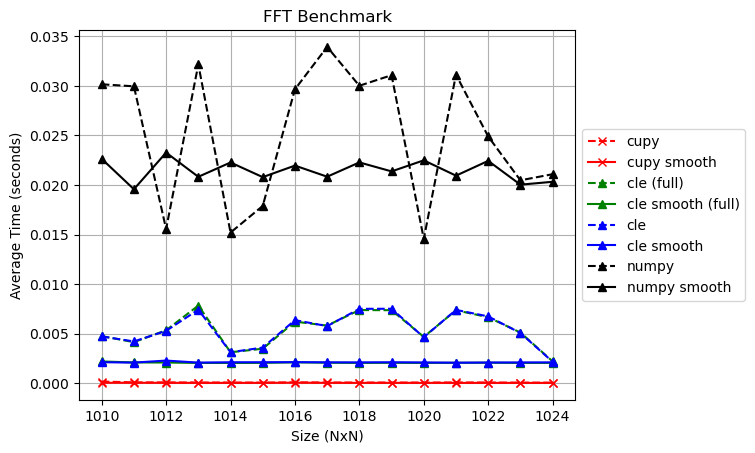

In [23]:

import matplotlib.pyplot as plt

plt.plot(sizes, cp_times, marker='x', color='r', linestyle='--', label="cupy")
plt.plot(sizes, cp_times_smooth, marker='x', color='r', label="cupy smooth")
plt.plot(sizes, cle_times_1, marker='^', color='g', linestyle='--', label="cle (full)")
plt.plot(sizes, cle_times_smooth_1, marker='^', color='g', label="cle smooth (full)")
plt.plot(sizes, cle_times_2, marker='^', color='b', linestyle='--', label="cle")
plt.plot(sizes, cle_times_smooth_2, marker='^', color='b', label="cle smooth")
plt.plot(sizes, times, marker='^', color='k', linestyle='--', label="numpy")
plt.plot(sizes, times_smooth, marker='^', color='k', label="numpy smooth")
plt.xlabel('Size (NxN)')
plt.ylabel('Average Time (seconds)')
plt.title('FFT Benchmark')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

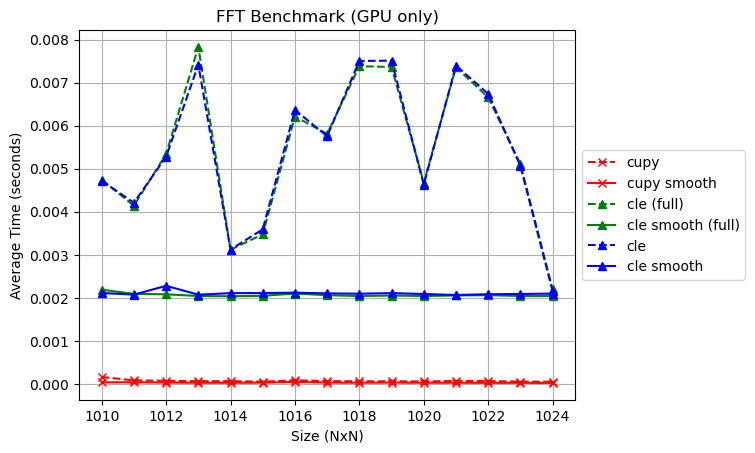

In [24]:
plt.plot(sizes, cp_times, marker='x', color='r', linestyle='--', label="cupy")
plt.plot(sizes, cp_times_smooth, marker='x', color='r', label="cupy smooth")
plt.plot(sizes, cle_times_1, marker='^', color='g', linestyle='--', label="cle (full)")
plt.plot(sizes, cle_times_smooth_1, marker='^', color='g', label="cle smooth (full)")
plt.plot(sizes, cle_times_2, marker='^', color='b', linestyle='--', label="cle")
plt.plot(sizes, cle_times_smooth_2, marker='^', color='b', label="cle smooth")
plt.xlabel('Size (NxN)')
plt.ylabel('Average Time (seconds)')
plt.title('FFT Benchmark (GPU only)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()